In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, precision_recall_curve, auc, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, AdamW
import pandas as pd
import numpy as np
import os
import pathlib
import gdown
import math
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC
from keras.saving import register_keras_serializable
print(tf.__version__)
!python --version
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

# Dataset Generators

In [ ]:
IMG_SIZE = (224, 224)

def load_image(rel_path):
    try:
        img = np.load(rel_path + ".npy")
        return img
    except Exception as e:
        raise ValueError(f"Failed to load .npy file: {rel_path}\n{e}")

def make_generator(df):
    def generator():
        for _, row in df.iterrows():
            img1 = load_image(row["sample_1"])
            img2 = load_image(row["sample_2"])
            label = np.array(row["label"], dtype=np.float32)
            yield (img1, img2), label
    return generator

texture_cvl/CVL0196/CVL0196_6/CVL0196_6_T9
Image shape: (224, 224, 3)
Pixel value range: 0.0 to 1.0


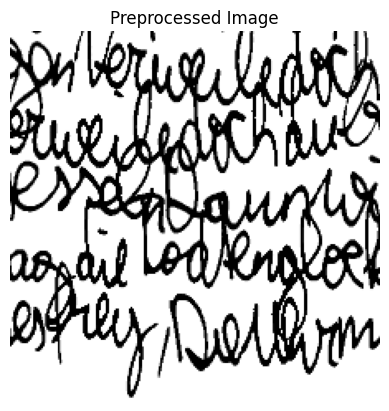

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_df = pd.read_parquet('train.parquet')
val_df = pd.read_parquet('val.parquet')

sample_path = train_df.iloc[0]["sample_1"]
print(sample_path)
img = load_image(sample_path)

# Print details
print("Image shape:", img.shape)
print("Pixel value range:", np.min(img), "to", np.max(img))

plt.imshow(img)
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

# Siamese Model Definition

In [3]:
@register_keras_serializable()
def l2_normalize(x):
    return tf.math.l2_normalize(x, axis=1)

@register_keras_serializable()
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

@register_keras_serializable()
def contrastive_loss(y_true, y_pred):
    square_pred = tf.square(y_pred)
    margin = 0.7
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

@register_keras_serializable()
def output_shape(input_shapes):
    return (input_shapes[0][0], 1)

output_signature = (
    (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(), dtype=tf.float32)
)

In [ ]:
base_cnn = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
flatten = GlobalAveragePooling2D()(base_cnn.output)
dense_1 = Dense(512,
                activation = 'relu',
                name='dense_1',
                )(flatten)
dense_2 = Dense(256,
                activation='relu',
                name='dense_2'
                )(dense_1)
emb = Lambda(l2_normalize, name='head_l2_norm')(dense_2)
feature_extractor = Model(base_cnn.input, emb, name='cnn_backbone')

input_a = Input(shape=(224, 224, 3), name='input_a')
input_b = Input(shape=(224, 224, 3), name='input_b')

feat_a = feature_extractor(input_a)
feat_b = feature_extractor(input_b)

output_layer = Lambda(euclidean_distance, output_shape=output_shape, name='euclidean_distance')([feat_a, feat_b])

siamese_net = Model(inputs=[input_a, input_b], outputs=output_layer, name='siamese_net')

siamese_net.compile(
    loss=contrastive_loss,
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=[AUC(name="roc_auc")]
    )

siamese_net.summary()

E0000 00:00:1746330958.055730    3357 ptx_compiler_helpers.cc:88] *** WARNING *** Invoking ptxas with version 12.5.82, which corresponds to a CUDA version <=12.6.2. CUDA versions 12.x.y up to and including 12.6.2 miscompile certain edge cases around clamping.
Please upgrade to CUDA 12.6.3 or newer.


Model: "siamese_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_backbone        │ (None, 256)       │ 15,108,672 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_distance  │ (None, 1)         │          0 │ cnn_backbone[0][… │
│ (Lambda)            │                   │            │ cnn_backbone[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,108,672 (57.64 MB)

 Trainable params: 15,108,672 (57.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_generator(
    lambda: make_generator(train_df)(),
    output_signature=output_signature
).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: make_generator(val_df)(),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

checkpoint_callback = ModelCheckpoint(
    filepath='best_siamese_model.keras',
    monitor='val_roc_auc',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_roc_auc',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

class DistanceHistCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, batches_to_use=100, log_dir="histograms"):
        super().__init__()
        self.val_ds = val_ds
        self.batches_to_use = batches_to_use
        self.log_dir = pathlib.Path(log_dir)
        self.log_dir.mkdir(exist_ok=True, parents=True)

    def on_epoch_end(self, epoch, logs=None):
        dists, labels = [], []

        for i, ((img1, img2), y) in enumerate(self.val_ds):
            if i >= self.batches_to_use:
                break
            pred = self.model.predict([img1, img2],
                                      verbose=0).ravel()
            dists.append(pred)
            labels.append(y.numpy())

        dists  = np.concatenate(dists)
        labels = np.concatenate(labels)

        neg = dists[labels == 0]
        pos = dists[labels == 1]

        plt.figure(figsize=(6, 4))
        plt.hist(neg, bins=50, alpha=0.6, label="Same Writer")
        plt.hist(pos, bins=50, alpha=0.6, label="Different Writer")
        plt.title(f"Distance distribution - epoch {epoch + 1}")
        plt.xlabel("Euclidean distance")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()

        fname = self.log_dir / f"epoch_{epoch + 1:03d}.png"
        plt.savefig(fname, dpi=120)
        plt.close()

# class MarginDecay(tf.keras.callbacks.Callback):
#     def __init__(self, loss_obj, end=0.5, decay=0.97):
#         self.loss_obj = loss_obj
#         self.end      = end
#         self.decay    = decay

#     def on_epoch_begin(self, epoch, logs=None):
#         new_m = max(self.end, self.loss_obj.margin.numpy() * self.decay)
#         self.loss_obj.margin.assign(new_m)
#         tf.print(f"\n[MarginDecay] margin →", new_m)

# margin_cb = MarginDecay(loss, end=0.5, decay=0.95)

# class MarginWarmup(tf.keras.callbacks.Callback):
#     def __init__(self, loss_obj, start=0.5, end=1.0, epochs=30):
#         super().__init__()
#         self.loss_obj = loss_obj
#         self.start    = start
#         self.end      = end
#         self.epochs   = epochs

#     def on_epoch_begin(self, epoch, logs=None):
#         # linearly interpolate margin
#         new_m = self.start + (self.end - self.start) * min(epoch / (self.epochs - 1), 1.0)
#         self.loss_obj.margin.assign(new_m)
#         tf.print(f"[MarginWarmup] margin →", new_m)

# margin_warmup = MarginWarmup(loss, start=0.7, end=1, epochs=15)

histogram_callback = DistanceHistCallback(
    val_ds          = val_dataset,
    batches_to_use  = 50
)

!rm -rf histograms
!mkdir histograms

In [ ]:
for layer in base_cnn.layers[:11]:
    layer.trainable = False
for layer in base_cnn.layers[11:]:
    layer.trainable = True

siamese_net.compile(
    loss=contrastive_loss,
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=[AUC(name="roc_auc")]
)

siamese_net.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE),
    validation_steps = math.ceil(len(val_df) / BATCH_SIZE),
    callbacks=[checkpoint_callback, early_stopping_callback, histogram_callback]
)

for layer in base_cnn.layers:
    layer.trainable = True

siamese_net.compile(
    loss=contrastive_loss,
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=[AUC(name="roc_auc")]
)
siamese_net.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    initial_epoch=5,
    steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE),
    validation_steps = math.ceil(len(val_df) / BATCH_SIZE),
    callbacks=[checkpoint_callback, early_stopping_callback, histogram_callback]
)


# Smoke Test

In [ ]:
for (img1_batch, img2_batch), label_batch in val_dataset.take(1):
    predictions = siamese_net.predict([img1_batch, img2_batch])

    for i in range(min(10, len(predictions))):
        print(f"Label: {int(label_batch[i].numpy())}, Distance: {predictions[i][0]:.4f}")
    break  # Only take one batch


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Label: 1, Distance: 0.5780
Label: 0, Distance: 0.3906
Label: 1, Distance: 0.7910
Label: 0, Distance: 0.3896
Label: 0, Distance: 0.4384
Label: 1, Distance: 0.7511
Label: 1, Distance: 1.0205
Label: 1, Distance: 1.0115
Label: 0, Distance: 0.8437
Label: 1, Distance: 0.6628


# Threshold Tuning

In [ ]:
def plot_scatter(labels, scores, dataset="Test"):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(scores)), scores, c=labels, cmap='coolwarm', label='Distance', alpha=0.4)
    plt.title(f'[{dataset}] Predicted Distances Colored by Label')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.colorbar(label='True Label (0: Same, 1: Different)')
    plt.grid(True)
    plt.show()

def plot_histogram(labels, scores, dataset="Test"):
    plt.figure(figsize=(10, 5))
    plt.hist(scores[labels == 0], bins=50, alpha=0.6, label='Same Writer')
    plt.hist(scores[labels == 1], bins=50, alpha=0.6, label='Different Writer')
    plt.title(f'[{dataset}] Predicted Distances Histogram')
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

model = tf.keras.models.load_model("best_siamese_model.keras",safe_mode=False)

thresholds = {'eer': 0, 'f1': 0, 'bf': 0}

val_dist = model.predict(val_dataset).ravel()
val_lab  = val_df["label"].to_numpy().astype(int)

plot_histogram(val_lab, val_dist, "Validation")

fpr, tpr, thr = roc_curve(val_lab, val_dist)
eer_idx  = np.argmin(np.abs(fpr - (1 - tpr)))
eer_thr  = thr[eer_idx]
thresholds['eer'] = eer_thr
print(f"EER threshold = {eer_thr:.3f}")

prec, rec, thr_pr = precision_recall_curve(val_lab, val_dist)
thr_pr = np.append(thr_pr, thr_pr[-1])           # align lengths
f1 = 2 * prec * rec / (prec + rec + 1e-8)
f1_thr = thr_pr[np.argmax(f1)]
thresholds['f1'] = f1_thr

print(f"F1-opt threshold = {f1_thr:.3f}")

best_acc = 0.0
best_thr = 0.0
for t in np.linspace(0.0, 1.4, 1410):
    preds = (val_dist > t).astype(int)
    acc   = (preds == val_lab).mean()
    if acc > best_acc:
        best_acc, best_thr = acc, t
thresholds['bf'] = best_thr

print(f"Best threshold = {best_thr:.2f},  accuracy = {best_acc:.3%}")

In [ ]:
BATCH_SIZE = 64

test_dataset = tf.data.Dataset.from_generator(
    lambda: make_generator(test_df)(),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_df = pd.read_parquet("Data_V4/test.parquet")

scores = model.predict(test_dataset, verbose=0).ravel()
labels  = test_df["label"].to_numpy().astype(int)
# plot_histogram(labels, scores)

In [ ]:
for kind, threshold in thresholds.items():
  test_pred = (scores >= threshold).astype(int)
  acc  = accuracy_score(labels, test_pred)
  prec, rec, f1, _ = precision_recall_fscore_support(labels, test_pred, average="binary")
  auc  = roc_auc_score(labels, scores)
  print(f"Threshold used     : {kind}")
  print(f"Threshold          : {threshold}")
  print(f"ROC-AUC            : {auc:.4f}")
  print(f"Accuracy           : {acc:.4f}")
  print(f"Precision          : {prec:.4f}")
  print(f"Recall             : {rec:.4f}")
  print(f"F1-score           : {f1:.4f}")
  print()